In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model
from interp_helpers import plot_attribution_all_targets

%load_ext autoreload
%autoreload 2

In [2]:
sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 11,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })

In [3]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

run = 36 # fm.get_latest_run()
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

Using cpu device


In [4]:
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
T = model_info['dataloader']['Sequence length (T)']

In [5]:
sequences = [
    'RRRRRR',
    'LLLLLL',
    'RRRRRr',
    'RRRRrr',
    'RRRrrr',
    'RRRrLr',
    'RRRrLL',
]

In [7]:
def get_module_by_path(model, path):
    """Access a module using a string path"""
    modules = path.split('.')
    current = model
    for module in modules:
        if module.isdigit():
            current = current[int(module)]
        else:
            current = getattr(current, module)
    return current


In [8]:
model.transformer.named_modules

<bound method Module.named_modules of ModuleDict(
  (wte): Embedding(4, 4)
  (wpe): Embedding(6, 4)
  (h): ModuleList(
    (0): Block(
      (ln_1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (c_attn): Linear(in_features=4, out_features=12, bias=True)
        (c_proj): Linear(in_features=4, out_features=4, bias=True)
      )
      (ln_2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Linear(in_features=4, out_features=16, bias=True)
        (gelu): GELU(approximate='tanh')
        (c_proj): Linear(in_features=16, out_features=4, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
)>

## Input-scaled/activation-scaled gradient attribution

For a sequence input:
$$
\begin{align}
[x_0, x_1, ..., x_T]
\end{align}
$$

that produces output logits $y$ (with dimensionality equal to vocabulary size), we compute:
$$
\begin{align}
x_0 (∂y/∂x_0) \\
x_1 (∂y/∂x_1) \\
... \\
x_T (∂y/∂x_T)
\end{align}
$$

$x_i$ are actually embedding vectors, not the token indices themselves. We compute the gradients of the logit for a particular target with respect to each input embedding, then multiply each embedding by its corresponding gradient.

We then generalize this approach to all layers of the model, such that attribution is defined as the gradient at the layer of interest for a particular target, scaled by the activation at that layer.

In [49]:
def compute_layer_attribution(model, sequence, stoi, target_token_idx, layers_of_interest=None):
    """
    Compute attributions for specified layers within the model.
    
    Args:
        model: The transformer model
        sequence: Input character sequence
        stoi: String to index mapping dictionary
        target_token_idx: Token index for which to compute attribution
        layers_of_interest: Dict mapping layer names to module paths or direct module references
                            If None, defaults to embedding layers
    
    Returns:
        Dictionary mapping layer names to attribution scores
    """

    def setup_hooks(layers_of_interest):

        # Track activations and gradients for each layer
        layer_activations = {name: [] for name in layers_of_interest}
        layer_gradients = {name: [] for name in layers_of_interest}
        hooks = []
        
        # Register hooks for all layers of interest
        for layer_name, layer_module in layers_of_interest.items():
            def make_forward_hook(name):
                def hook(module, inp, out):
                    out.requires_grad_(True)
                    layer_activations[name].append(out.detach().clone())
                    
                    # Create backward hook
                    def grad_hook(grad):
                        layer_gradients[name].append(grad.detach().clone())
                        return grad
                    
                    out.register_hook(grad_hook)
                    return out
                return hook
            
            # Register the forward hook
            hook = layer_module.register_forward_hook(make_forward_hook(layer_name))
            hooks.append(hook)

        return layer_activations, layer_gradients, hooks

    # Default to embedding layers if no layers specified
    if layers_of_interest is None:
        layers_of_interest = {
            'token_embedding': model.transformer.wte,
            'position_embedding': model.transformer.wpe
        }

    token_ids = [stoi[char] for char in sequence]
    input_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(model.device)
    
    # Train mode for gradient tracking
    original_mode = model.training
    model.train()

    try:
        layer_activations, layer_gradients, hooks = setup_hooks(layers_of_interest)
        
        # Forward pass (without targets to avoid computing loss)
        logits, _ = model(input_tensor, targets=None)
        
        # Create a target for the specific output token
        target = torch.zeros_like(logits)  # [batch, seq_len, vocab]
        target[0, -1, target_token_idx] = 1.0
        
        model.zero_grad()
        
        # Backward pass for this specific output logit
        logits.backward(target, retain_graph=True)
        
        # Compute attributions for each layer
        attributions = {}
        for layer_name in layers_of_interest:
            if layer_activations[layer_name] and layer_gradients[layer_name]:
                # Element-wise multiplication and sum along feature dimension
                layer_activation = layer_activations[layer_name][0]
                layer_gradient = layer_gradients[layer_name][0]
                attribution = (layer_activation * layer_gradient).sum(dim=-1)
                attributions[layer_name] = attribution.cpu().numpy().squeeze()
            else:
                print(f"Warning: No activations or gradients captured for {layer_name}")
                attributions[layer_name] = None

        if ('token_embedding' in layers_of_interest.keys()) & ('position_embedding' in layers_of_interest.keys()):
            attributions['combined'] = attributions['token_embedding'] + attributions['position_embedding']
    finally:
        for hook in hooks:
            hook.remove()
    
        model.train(original_mode)
    
    return attributions

In [56]:
layers_to_analyze = {
    'token_embedding': 'transformer.wte',
    'position_embedding': 'transformer.wpe',
    'layer0_attn': 'transformer.h.0.attn',
    'layer0_mlp': 'transformer.h.0.mlp',
}

layers_to_analyze = {name: get_module_by_path(model, path) for name, path in layers_to_analyze.items()}


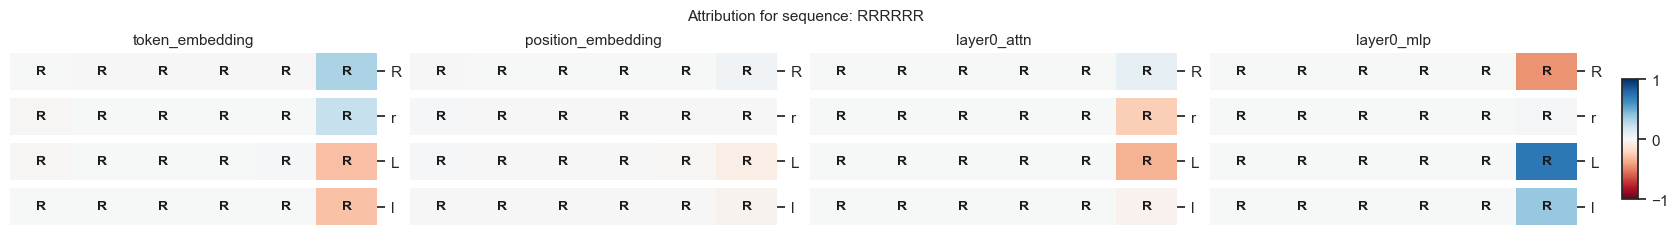

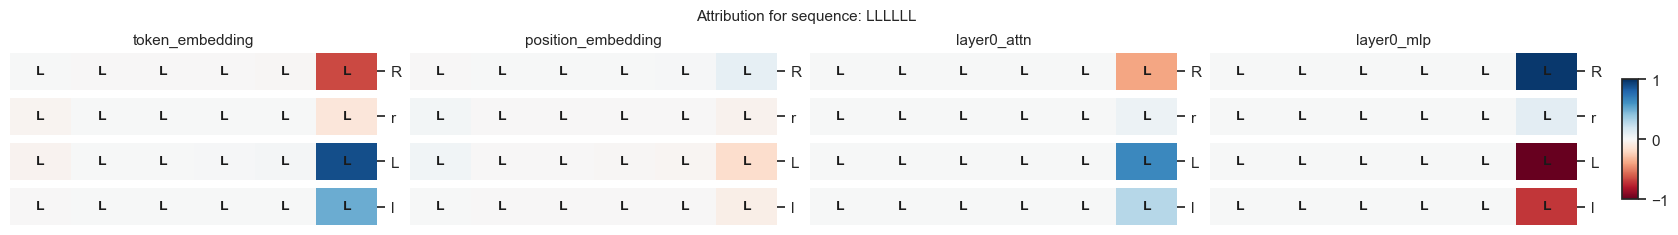

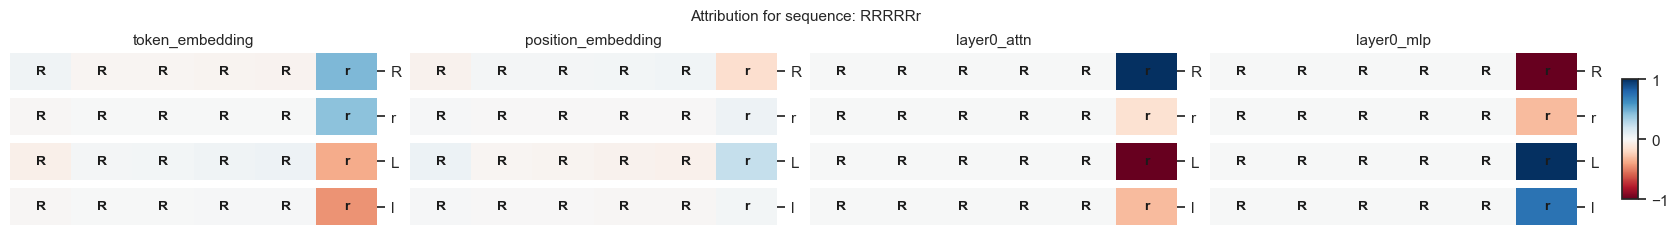

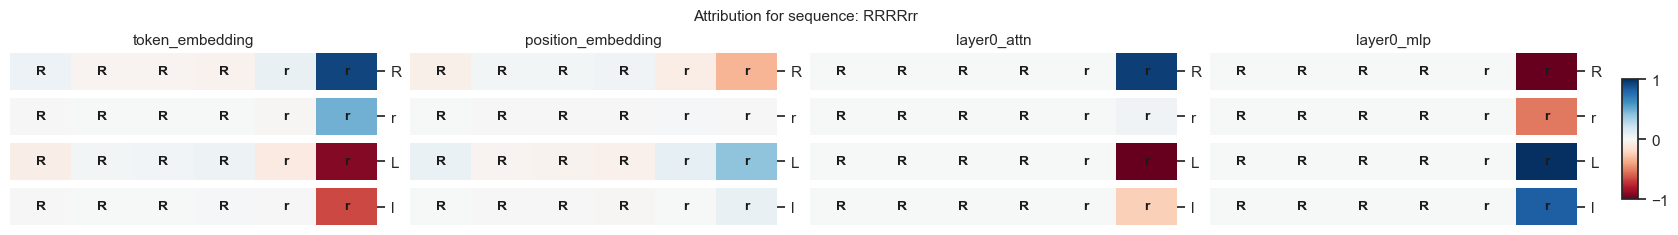

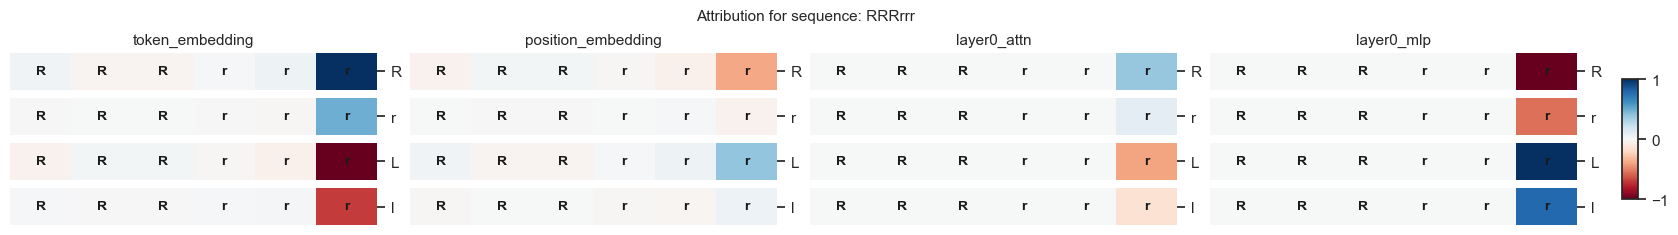

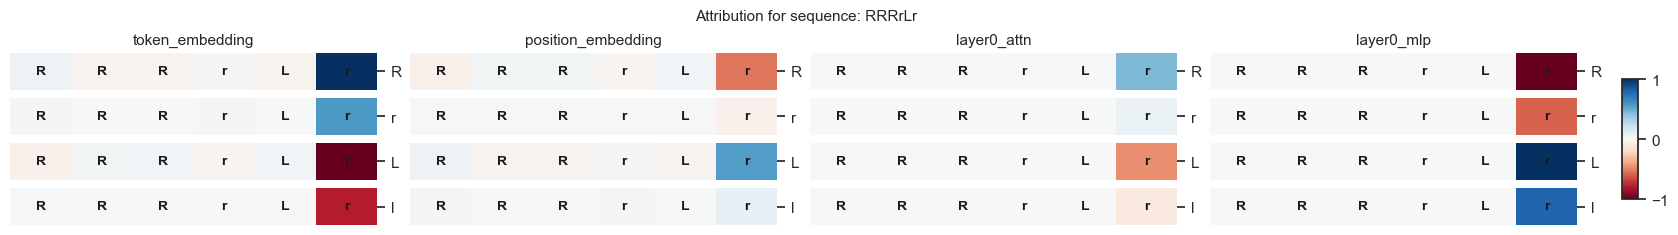

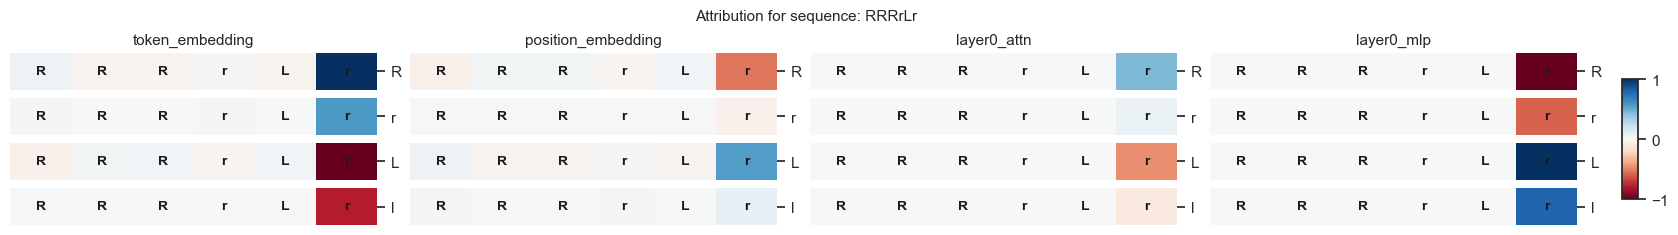

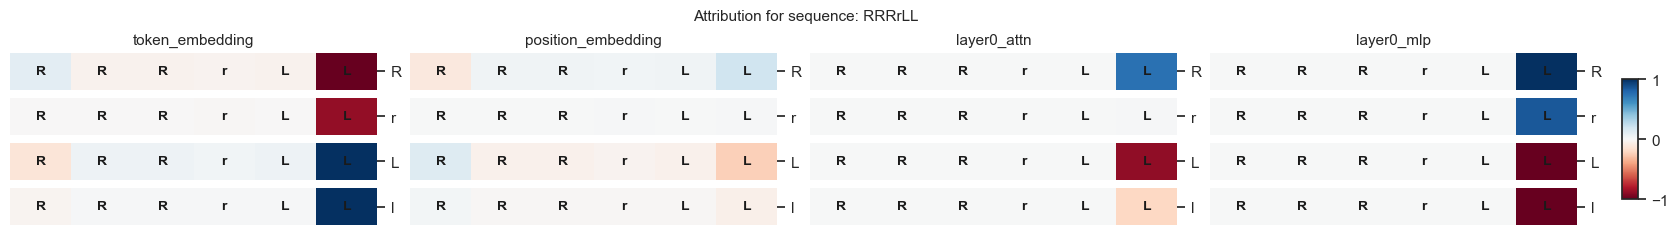

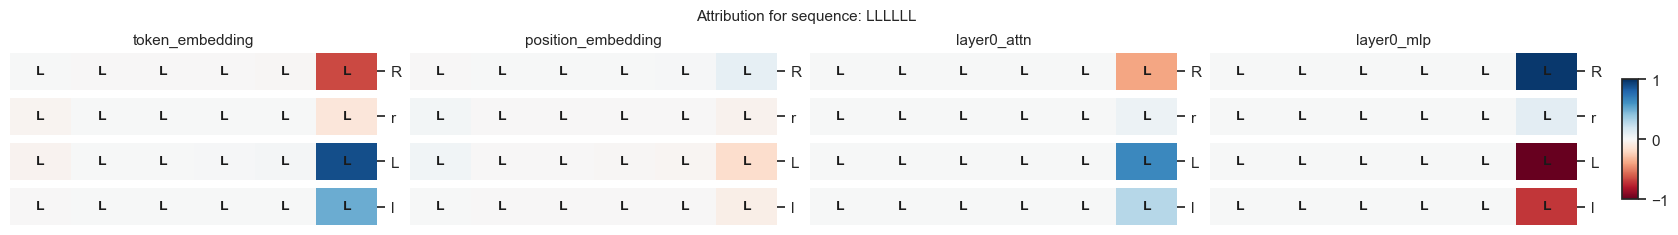

In [57]:
plot_attribution_all_targets(compute_layer_attribution, model, sequences, vocab, stoi, layers_of_interest=layers_to_analyze, ncols=len(layers_to_analyze))

## Integrated gradients

In [174]:
# Create a subclass of the model to handle embedding replacement
class ModelWithCustomEmbeddings(torch.nn.Module):
    def __init__(self, base_model, custom_embeddings):
        super().__init__()
        self.base_model = base_model
        self.custom_embeddings = custom_embeddings
        
    def forward(self, idx, targets=None):
        # Skip the embedding lookup in the original model
        # and start with our custom embeddings
        B, T = idx.size()
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        
        # Use our pre-computed embeddings instead of doing the lookup
        x = self.custom_embeddings
        
        # Process through transformer blocks
        for block in self.base_model.transformer.h:
            x = block(x)
        
        # Final layer norm and projection to vocab
        x = self.base_model.transformer.ln_f(x)
        logits = self.base_model.lm_head(x)
        
        return logits, None

def compute_integrated_gradients(model, sequence, stoi, target_token_idx, reference_sequence='RRRRRR', steps=20, layers_of_interest=None):
    """
    Compute integrated gradients attributions for specified layers within the model.
    
    Args:
        model: The transformer model
        sequence: Input character sequence
        reference_sequence: Baseline sequence (e.g., 'RRRRRR')
        stoi: String to index mapping dictionary
        target_token_idx: Token index for which to compute attribution
        steps: Number of interpolation steps
        layers_of_interest: Dict mapping layer names to module paths or direct module references
                            If None, defaults to embedding layers
    
    Returns:
        Dictionary mapping layer names to integrated gradients attribution scores
    """
    
    def setup_hooks(layers_of_interest):
        # Track activations and gradients for each layer
        layer_activations = {name: [] for name in layers_of_interest}
        layer_gradients = {name: [] for name in layers_of_interest}
        hooks = []
        
        # The primary hook that captures gradients for interpolated embeddings
        def grad_hook(grad):
            # Store gradients for token and position embeddings
            layer_gradients['token_embedding'].append(grad.detach().clone())
            return grad
        
        # Register the hook on our interpolated embeddings
        interpolated_embeds.register_hook(grad_hook)

        # Register hooks for all layers of interest
        for layer_name, layer_module in layers_of_interest.items():
            def make_forward_hook(name):
                def hook(module, inp, out):
                    if isinstance(out, tuple):
                        tracked_out = out[0].detach().clone().requires_grad_(True)
                    else:
                        tracked_out = out.detach().clone().requires_grad_(True)
                    layer_activations[name].append(tracked_out)
                    
                    # Create backward hook
                    def grad_hook(grad):
                        layer_gradients[name].append(grad.detach().clone())
                        return grad
                    
                    tracked_out.register_hook(grad_hook)
                    return out
                return hook
            
            # Register the forward hook
            hook = layer_module.register_forward_hook(make_forward_hook(layer_name))
            hooks.append(hook)

        return layer_activations, layer_gradients, hooks

    # Default to embedding layers if no layers specified
    if layers_of_interest is None:
        layers_of_interest = {
            'token_embedding': model.transformer.wte,
        }

    # Convert sequences to token IDs
    input_ids = torch.tensor([stoi[char] for char in sequence], dtype=torch.long).unsqueeze(0).to(model.device)
    reference_ids = torch.tensor([stoi[char] for char in reference_sequence], dtype=torch.long).unsqueeze(0).to(model.device)
    
    # Store original training mode and set to train for gradient tracking
    original_mode = model.training
    model.train()
    
    # Get the original embeddings (without hooking)
    with torch.no_grad():
        # Get token embeddings for input and reference
        input_token_embeds = model.transformer.wte(input_ids)
        reference_token_embeds = model.transformer.wte(reference_ids)
        
        # Get position embeddings
        positions = torch.arange(len(sequence), device=model.device).unsqueeze(0)
        input_pos_embeds = model.transformer.wpe(positions)
        reference_pos_embeds = input_pos_embeds.clone()  # Position embeddings are the same
    
    # Initialize integrated gradients for each layer
    integrated_grads = {name: None for name in layers_of_interest}

    try:
        # For each interpolation step
        for step in range(steps):
            # Clean previous gradients
            model.zero_grad()
            
            # Create interpolated embeddings
            alpha = step / (steps - 1)
            interpolated_token_embeds = reference_token_embeds + alpha * (input_token_embeds - reference_token_embeds)
            interpolated_pos_embeds = reference_pos_embeds   # Position embeddings stay the same
            interpolated_embeds = interpolated_token_embeds + interpolated_pos_embeds
            # We need the interpolated embeddings to require gradients
            interpolated_embeds = interpolated_embeds.detach().requires_grad_(True)
    
            custom_model = ModelWithCustomEmbeddings(model, interpolated_embeds)

            try:
                # Set up hooks for this step
                layer_activations, layer_gradients, hooks = setup_hooks(layers_of_interest)
                # Forward pass using the interpolated embeddings
                logits, _ = custom_model(input_ids, targets=None)
                
                # Create a target for the specific output token
                target = torch.zeros_like(logits)
                target[0, -1, target_token_idx] = 1.0
                
                # Backward pass for this specific output logit
                logits.backward(target, retain_graph=False)
                
                # Accumulate gradients for each layer
                for layer_name in layers_of_interest:
                    if layer_gradients[layer_name]:
                        # Get the gradient for this step
                        step_gradient = layer_gradients[layer_name][0]
                        if integrated_grads[layer_name] is None:
                            integrated_grads[layer_name] = torch.zeros_like(step_gradient)
                        # Add to the accumulator (scaled by step size)
                        integrated_grads[layer_name] += step_gradient / steps
                    else:
                        print(f"Warning: No gradients captured for {layer_name} at step {step}")
            
            finally:
                # Remove hooks for this step
                for hook in hooks:
                    hook.remove()
    
        # Final attribution calculation
        attributions = {}
        for layer_name in layers_of_interest:
            if integrated_grads[layer_name] is not None:
                if layer_name == 'token_embedding':
                    # For token embeddings, multiply by (input - reference)
                    attribution = integrated_grads[layer_name] * (input_token_embeds - reference_token_embeds)
                else:
                    attribution = integrated_grads[layer_name]
                attributions[layer_name] = attribution.sum(dim=-1).cpu().numpy().squeeze()
    
    finally:
        # Restore original model state
        model.train(original_mode)
    
    return attributions

In [12]:
import types

def compute_integrated_gradients(model, sequence, stoi, target_token_idx, reference_sequence='RRRRRR', steps=20, layers_of_interest=None):
    """
    Compute integrated gradients attributions for specified layers within the model.
    """
    # Default to embedding layers if no layers specified
    if layers_of_interest is None:
        layers_of_interest = {
            'token_embedding': model.transformer.wte,
        }

    # Convert sequences to token IDs
    input_ids = torch.tensor([stoi[char] for char in sequence], dtype=torch.long).unsqueeze(0).to(model.device)
    reference_ids = torch.tensor([stoi[char] for char in reference_sequence], dtype=torch.long).unsqueeze(0).to(model.device)
    
    # Store original training mode and set to train for gradient tracking
    original_mode = model.training
    model.train()
    
    # Get token embeddings
    with torch.no_grad():
        input_token_embeds = model.transformer.wte(input_ids)
        reference_token_embeds = model.transformer.wte(reference_ids)
        positions = torch.arange(len(sequence), device=model.device).unsqueeze(0)
        pos_embeds = model.transformer.wpe(positions)
    
    # Initialize integrated gradients
    token_emb_grads = []
    attn_grads = {name: [] for name in layers_of_interest if name != 'token_embedding'}
    
    # Store original forward method
    original_forward = model.forward
    
    try:
        # Define a custom forward that retains references to important modules
        def custom_forward(self, idx, targets=None):
            # Use the interpolated embeddings
            x = self.custom_embeddings
            
            # Store intermediate activations
            self.activations = {}
            
            # Process through transformer blocks
            for i, block in enumerate(self.transformer.h):
                # First, trigger any registered hooks on the specific block
                # and its components like attention
                x = block(x)
            
            # Final layer norm and projection to vocab
            x = self.transformer.ln_f(x)
            logits = self.lm_head(x)
            
            return logits, None
        
        # For each interpolation step
        for step in range(steps):
            model.zero_grad()
            
            # Calculate alpha for this step
            alpha = step / (steps - 1)
            
            # Create interpolated embeddings
            interpolated_token_embeds = reference_token_embeds + alpha * (input_token_embeds - reference_token_embeds)
            interpolated_token_embeds.requires_grad_(True)
            combined_embeds = interpolated_token_embeds + pos_embeds
            
            # Register hooks for all non-embedding layers
            hooks = []
            for layer_name, layer in layers_of_interest.items():
                if layer_name != 'token_embedding':
                    # Register backward hook directly on the module
                    def make_backward_hook(name):
                        def hook(module, grad_input, grad_output):
                            # Only take the first grad_output
                            if grad_output and len(grad_output) > 0:
                                attn_grads[name].append(grad_output[0].detach().clone())
                            return grad_input
                        return hook
                    
                    # Register a backward hook
                    handle = layer.register_full_backward_hook(make_backward_hook(layer_name))
                    hooks.append(handle)
            
            # Set up our custom embeddings and forward method
            model.custom_embeddings = combined_embeds
            model.forward = types.MethodType(custom_forward, model)
            
            # Forward pass
            logits, _ = model(input_ids)
            
            # Create target for backpropagation
            target = torch.zeros_like(logits)
            target[0, -1, target_token_idx] = 1.0
            
            # Backward pass
            logits.backward(target)
            
            # Store token embedding gradients
            if interpolated_token_embeds.grad is not None:
                token_emb_grads.append(interpolated_token_embeds.grad.clone())
            
            # Clean up hooks
            for hook in hooks:
                hook.remove()
    
    finally:
        # Restore original forward method
        model.forward = original_forward
        # Restore training mode
        model.train(original_mode)
    
    # Calculate attributions
    attributions = {}
    
    # Token embeddings attribution
    if token_emb_grads:
        avg_grad = sum(token_emb_grads) / len(token_emb_grads)
        attributions['token_embedding'] = (avg_grad * (input_token_embeds - reference_token_embeds)).sum(dim=-1).cpu().numpy().squeeze()
    
    # Attribution for attention and other layers
    for name in attn_grads:
        if attn_grads[name]:
            avg_grad = sum(attn_grads[name]) / len(attn_grads[name])
            attributions[name] = avg_grad.sum(dim=-1).cpu().numpy().squeeze()
    
    return attributions

In [19]:
layers_to_analyze = {
    'token_embedding': 'transformer.wte',
    'position_embedding': 'transformer.wpe',
    'layer0_attn': 'transformer.h.0.attn',
    'layer0_mlp': 'transformer.h.0.mlp',
}
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)
layers_to_analyze = {name: get_module_by_path(model, path) for name, path in layers_to_analyze.items()}
layers_to_analyze

compute_integrated_gradients(model, 'RRRlrL', stoi, 0, steps=2, layers_of_interest=layers_to_analyze)
plot_attribution_all_targets(compute_integrated_gradients, model, ['RRRRrr'], vocab, stoi, steps=20, layers_of_interest=layers_to_analyze, ncols=len(layers_to_analyze))

{'token_embedding': array([ 0.        ,  0.        ,  0.        , -0.38590813, -0.5430077 ,
        -4.0565276 ], dtype=float32),
 'layer0_attn': array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.1920929e-07], dtype=float32),
 'layer0_mlp': array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.1920929e-07], dtype=float32)}

In [180]:
import types

def compute_integrated_gradients(model, sequence, stoi, target_token_idx, reference_sequence='RRRRRR', steps=20, layers_of_interest=None):
    """
    Compute integrated gradients attributions for specified layers within the model.
    
    Args:
        model: The transformer model
        sequence: Input character sequence
        reference_sequence: Baseline sequence (e.g., 'RRRRRR')
        stoi: String to index mapping dictionary
        target_token_idx: Token index for which to compute attribution
        steps: Number of interpolation steps
        layers_of_interest: Dict mapping layer names to module paths or direct module references
                            If None, defaults to embedding layers
    
    Returns:
        Dictionary mapping layer names to integrated gradients attribution scores
    """
    # Default to embedding layers if no layers specified
    if layers_of_interest is None:
        layers_of_interest = {
            'token_embedding': model.transformer.wte,
        }

    # Convert sequences to token IDs
    input_ids = torch.tensor([stoi[char] for char in sequence], dtype=torch.long).unsqueeze(0).to(model.device)
    reference_ids = torch.tensor([stoi[char] for char in reference_sequence], dtype=torch.long).unsqueeze(0).to(model.device)
    
    # Store original training mode and set to train for gradient tracking
    original_mode = model.training
    model.train()
    
    # Get the original embeddings
    with torch.no_grad():
        # Get token embeddings for input and reference
        input_token_embeds = model.transformer.wte(input_ids)
        reference_token_embeds = model.transformer.wte(reference_ids)
        # Get position embeddings
        positions = torch.arange(len(sequence), device=model.device).unsqueeze(0)
        pos_embeds = model.transformer.wpe(positions)
    
    # Initialize integrated gradients for each layer
    integrated_grads = {name: None for name in layers_of_interest}
    
    # Store the original forward method to restore it later
    original_forward = model.forward
    
    try:
        # Define a new forward method that uses interpolated embeddings
        def custom_forward(self, idx, targets=None, **kwargs):
            B, T = idx.size()
            
            # Use our pre-computed interpolated embeddings
            x = self.interpolated_embeds
            
            # Process through transformer blocks
            for block in self.transformer.h:
                x = block(x)
            
            # Final layer norm and projection to vocab
            x = self.transformer.ln_f(x)
            logits = self.lm_head(x)
            
            # Don't compute loss
            return logits, None
        
        # For each interpolation step
        for step in range(steps):
            # Create interpolated embeddings
            alpha = step / (steps - 1)
            interpolated_token_embeds = reference_token_embeds + alpha * (input_token_embeds - reference_token_embeds)
            interpolated_embeds = interpolated_token_embeds + pos_embeds
            
            # Clean previous gradients
            model.zero_grad()
            
            # Set up hook functions to capture activations and gradients
            activation_dict = {name: [] for name in layers_of_interest}
            gradient_dict = {name: [] for name in layers_of_interest}
            hooks = []
            print(layers_of_interest)
            # Register hooks for each layer of interest
            for layer_name, layer in layers_of_interest.items():
                def get_activation_hook(name):
                    def hook(module, input, output):
                        activation_dict[name].append(output.detach().clone())
                        
                        # Register backward hook on the output
                        def grad_hook(grad):
                            gradient_dict[name].append(grad.detach().clone())
                            return grad
                        output.register_hook(grad_hook)
                    return hook
                
                # Register the hook on this layer
                hooks.append(layer.register_forward_hook(get_activation_hook(layer_name)))
            
            # Attach the interpolated embeddings to the model
            model.interpolated_embeds = interpolated_embeds.requires_grad_(True)
            
            # Temporarily replace the forward method
            model.forward = types.MethodType(custom_forward, model)
            
            # Forward pass with our custom forward method
            logits, _ = model(input_ids)
            
            # Create a target for the specific output token
            target = torch.zeros_like(logits)
            target[0, -1, target_token_idx] = 1.0
            
            # Backward pass
            logits.backward(target)
            
            # Accumulate gradients for each layer
            for layer_name in layers_of_interest:
                if gradient_dict[layer_name]:
                    step_gradient = gradient_dict[layer_name][0]
                    if integrated_grads[layer_name] is None:
                        integrated_grads[layer_name] = torch.zeros_like(step_gradient)
                    integrated_grads[layer_name] += step_gradient / steps
                else:
                    print(f"Warning: No gradients captured for {layer_name} at step {step}")
            
            # Remove all hooks
            for hook in hooks:
                hook.remove()
        
        # Final attribution calculation
        attributions = {}
        for layer_name in layers_of_interest:
            if integrated_grads[layer_name] is not None:
                if layer_name == 'token_embedding':
                    # For token embeddings, multiply by (input - reference)
                    delta = (input_token_embeds - reference_token_embeds)
                    attribution = integrated_grads[layer_name] * delta
                else:
                    # For other layers, just use the accumulated gradients
                    if activation_dict[layer_name]:  # If we have activations, use them
                        act = activation_dict[layer_name][0]
                        attribution = integrated_grads[layer_name] * act
                    else:
                        attribution = integrated_grads[layer_name]
                attributions[layer_name] = attribution.sum(dim=-1).cpu().numpy().squeeze()
    
    finally:
        # Restore the original forward method
        model.forward = original_forward
        # Restore original model state
        model.train(original_mode)
    
    return attributions

In [211]:
def compute_integrated_gradients(model, sequence, stoi, target_token_idx, reference_sequence='RRRRRR', steps=20, layers_of_interest=None):
    """
    Compute integrated gradients attributions for specified layers within the model.
    """
    # Default to embedding layers if no layers specified
    if layers_of_interest is None:
        layers_of_interest = {
            'token_embedding': model.transformer.wte,
        }

    # Convert sequences to token IDs
    input_ids = torch.tensor([stoi[char] for char in sequence], dtype=torch.long).unsqueeze(0).to(model.device)
    reference_ids = torch.tensor([stoi[char] for char in reference_sequence], dtype=torch.long).unsqueeze(0).to(model.device)
    
    # Store original training mode and set to train for gradient tracking
    original_mode = model.training
    model.train()
    
    # Calculate baseline and input embeddings
    with torch.no_grad():
        input_emb = model.transformer.wte(input_ids)
        reference_emb = model.transformer.wte(reference_ids)
        pos_emb = model.transformer.wpe(torch.arange(len(sequence), device=model.device).unsqueeze(0))
    
    # Store the original forward method
    original_forward = model.forward
    
    # Initialize storage for integrated gradients
    integrated_grads = {name: None for name in layers_of_interest}
    
    try:
        # For each step of IG
        for step in range(steps):
            model.zero_grad()
            
            # Calculate alpha for this step
            alpha = step / (steps - 1)
            
            # Create interpolated embeddings
            interpolated_emb = reference_emb + alpha * (input_emb - reference_emb)
            interpolated_emb.requires_grad_(True)
            
            # Combined embeddings
            combined_emb = interpolated_emb + pos_emb
            
            # Create storage for activations and gradients
            activations = {}
            gradients = {}
            
            # Set up hooks for non-embedding layers
            hooks = []
            for name, layer in layers_of_interest.items():
                if name != 'token_embedding':  # Skip embedding layer since we handle it separately
                    def make_hook(layer_name):
                        def hook(module, inp, out):
                            # Clone and detach to avoid modifying the original computation
                            out_tensor = out
                            if isinstance(out, tuple):
                                out_tensor = out[0]
                            
                            # Save activation
                            activations[layer_name] = out_tensor.detach().clone().requires_grad_(True)
                            
                            # Register backward hook to capture gradients
                            def grad_hook(grad):
                                gradients[layer_name] = grad.detach().clone()
                                return grad
                            
                            activations[layer_name].register_hook(grad_hook)
                            
                            # Return original output to not disturb forward pass
                            return out
                        return hook
                    
                    # Register hook for this layer
                    hooks.append(layer.register_forward_hook(make_hook(name)))
            
            # Define a custom forward method
            def custom_forward(self, idx, targets=None):
                # Use the interpolated embeddings
                x = self.interpolated_embeds
                
                # Process through transformer blocks
                for block in self.transformer.h:
                    x = block(x)
                
                # Final layer norm and projection to vocab
                x = self.transformer.ln_f(x)
                logits = self.lm_head(x)
                
                return logits, None
            
            # Temporarily modify the model
            model.interpolated_embeds = combined_emb
            model.forward = types.MethodType(custom_forward, model)
            
            # Forward pass with interpolated embeddings
            logits, _ = model(input_ids)
            
            # Target for gradients
            target = torch.zeros_like(logits)
            target[0, -1, target_token_idx] = 1.0
            
            # Backward pass
            logits.backward(target)
            
            # Collect token embedding gradients
            for layer_name in layers_of_interest:
                if layer_name == 'token_embedding':
                    if interpolated_emb.grad is not None:
                        if integrated_grads['token_embedding'] is None:
                            integrated_grads['token_embedding'] = interpolated_emb.grad.clone() / steps
                    else:
                        integrated_grads['token_embedding'] += interpolated_emb.grad.clone() / steps
                else:
                    if layer_name in gradients:
                        # Get the gradient for this step
                        step_gradient = gradients[layer_name][0]
                        if integrated_grads[layer_name] is None:
                            integrated_grads[layer_name] = step_gradient / steps
                        # Add to the accumulator (scaled by step size)
                        integrated_grads[layer_name] += step_gradient / steps
                    else:
                        print(f"Warning: No gradients captured for {layer_name} at step {step}")

            # Clean up hooks
            for hook in hooks:
                hook.remove()
                
    finally:
        # Restore original forward method
        model.forward = original_forward
        model.train(original_mode)

    # Calculate attributions
    attributions = {}
    for layer_name in layers_of_interest:
        if integrated_grads[layer_name] is not None:
            if layer_name == 'token_embedding':
                # For token embeddings, multiply by (input - reference)
                attribution = integrated_grads[layer_name] * (input_emb - reference_emb)
            else:
                attribution = integrated_grads[layer_name]
            attributions[layer_name] = attribution.sum(dim=-1).cpu().numpy().squeeze()
    
    return attributions


In [245]:
def compute_integrated_gradients(model, sequence, stoi, target_token_idx, reference_sequence='RRRRRR', steps=20, layers_of_interest=None):
    """
    Compute integrated gradients attributions for specified layers within the model.
    
    Args:
        model: The transformer model
        sequence: Input character sequence
        reference_sequence: Baseline sequence (e.g., 'RRRRRR')
        stoi: String to index mapping dictionary
        target_token_idx: Token index for which to compute attribution
        steps: Number of interpolation steps
        layers_of_interest: Dict mapping layer names to module objects
    
    Returns:
        Dictionary mapping layer names to integrated gradients attribution scores
    """
    # Default to embedding layers if no layers specified
    if layers_of_interest is None:
        layers_of_interest = {
            'token_embedding': model.transformer.wte,
        }

    # Convert sequences to token IDs
    input_ids = torch.tensor([stoi[char] for char in sequence], dtype=torch.long).unsqueeze(0).to(model.device)
    reference_ids = torch.tensor([stoi[char] for char in reference_sequence], dtype=torch.long).unsqueeze(0).to(model.device)
    
    # Store original training mode and set to train for gradient tracking
    original_mode = model.training
    model.train()
    
    # Calculate baseline and input embeddings
    with torch.no_grad():
        input_emb = model.transformer.wte(input_ids)
        reference_emb = model.transformer.wte(reference_ids)
        pos_emb = model.transformer.wpe(torch.arange(len(sequence), device=model.device).unsqueeze(0))
    
    # Initialize storage for integrated gradients
    integrated_grads = {name: None for name in layers_of_interest}
    # Special handling for token embedding gradients
    token_emb_grads = []
    
    # Track layer activations and gradients
    layer_activations = {name: [] for name in layers_of_interest if name != 'token_embedding'}
    layer_gradients = {name: [] for name in layers_of_interest if name != 'token_embedding'}
    
    # For each interpolation step
    for step in range(steps):
        model.zero_grad()
        
        # Calculate alpha for this step
        alpha = step / (steps - 1)
        
        # Create interpolated embeddings
        interpolated_emb = reference_emb + alpha * (input_emb - reference_emb)
        interpolated_emb.requires_grad_(True)
        
        # Combined embeddings (token + positional)
        combined_emb = interpolated_emb + pos_emb
        
        # Set up hooks for attention and MLP layers
        hooks = []
        
        # Create hooks for all layers except token embedding
        for name, layer in layers_of_interest.items():
            print(name)
            if name != 'token_embedding':
                def make_forward_hook(layer_name):
                    def hook(module, inp, out):
                        # Store the activation
                        act = out
                        if isinstance(out, tuple):
                            act = out[0]
                        layer_activations[layer_name].append(act)
                        
                        # Register backward hook on the output
                        def grad_hook(grad):
                            layer_gradients[layer_name].append(grad.clone())
                            return grad
                        
                        act.register_hook(grad_hook)
                        return out
                    return hook
                
                # Register the forward hook for this layer
                h = layer.register_forward_hook(make_forward_hook(name))
                hooks.append(h)
        
        # Define a custom forward pass that uses our interpolated embeddings
        def forward_with_custom_embeddings(idx):
            # Replace token embeddings with our interpolated version
            token_emb = interpolated_emb  # This has requires_grad=True
            
            # Add positional embeddings
            x = token_emb + pos_emb
            
            # Process through transformer blocks
            for block in model.transformer.h:
                x = block(x)
            
            # Final layer norm and projection to vocab
            x = model.transformer.ln_f(x)
            logits = model.lm_head(x)
            
            return logits
        
        # Compute logits using our custom forward
        logits = forward_with_custom_embeddings(input_ids)
        
        # Set up target for backpropagation (one-hot for target token)
        target = torch.zeros_like(logits)
        target[0, -1, target_token_idx] = 1.0
        
        # Backward pass
        logits.backward(target)
        
        # Store token embedding gradients
        if interpolated_emb.grad is not None:
            token_emb_grads.append(interpolated_emb.grad.clone())
        
        # Clean up hooks
        for hook in hooks:
            hook.remove()
    
    # Restore model's original training mode
    model.train(original_mode)

    # Calculate integrated gradients for token embeddings
    if token_emb_grads:
        integrated_grads['token_embedding'] = sum(token_emb_grads) / len(token_emb_grads)
    print(layer_gradients)

    # Calculate integrated gradients for other layers
    for name in layer_gradients:
        if layer_gradients[name]:
            integrated_grads[name] = sum(layer_gradients[name]) / len(layer_gradients[name])
    
    # Calculate attributions
    attributions = {}
    
    # For token embeddings, multiply by (input - reference)
    if 'token_embedding' in integrated_grads and integrated_grads['token_embedding'] is not None:
        attribution = integrated_grads['token_embedding'] * (input_emb - reference_emb)
        attributions['token_embedding'] = attribution.sum(dim=-1).cpu().numpy().squeeze()
    
    # For other layers, use the gradients directly
    for name in integrated_grads:
        if name != 'token_embedding' and integrated_grads[name] is not None:
            attributions[name] = integrated_grads[name].sum(dim=-1).cpu().numpy().squeeze()
    
    return attributions

In [249]:
layers_to_analyze = {
    'token_embedding': 'transformer.wte',
    # 'position_embedding': 'transformer.wpe',
    'layer0_attn': 'transformer.h.0.attn',
    'layer0_mlp': 'transformer.h.0.mlp',
}

layers_to_analyze = {name: get_module_by_path(model, path) for name, path in layers_to_analyze.items()}


In [250]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

run = 36 # fm.get_latest_run()
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

Using cpu device


In [251]:
compute_integrated_gradients(model, 'RRRRrr', stoi, 0, steps=2, layers_of_interest=layers_to_analyze)

token_embedding
layer0_attn
layer0_mlp
token_embedding
layer0_attn
layer0_mlp
{'layer0_attn': [], 'layer0_mlp': []}


{'token_embedding': array([ 0.        ,  0.        ,  0.        ,  0.        , -0.64274096,
        -1.162041  ], dtype=float32)}

token_embedding
layer0_attn
layer0_mlp
token_embedding
layer0_attn
layer0_mlp
{'layer0_attn': [], 'layer0_mlp': []}
token_embedding
layer0_attn
layer0_mlp
token_embedding
layer0_attn
layer0_mlp
{'layer0_attn': [], 'layer0_mlp': []}
token_embedding
layer0_attn
layer0_mlp
token_embedding
layer0_attn
layer0_mlp
{'layer0_attn': [], 'layer0_mlp': []}
token_embedding
layer0_attn
layer0_mlp
token_embedding
layer0_attn
layer0_mlp
{'layer0_attn': [], 'layer0_mlp': []}


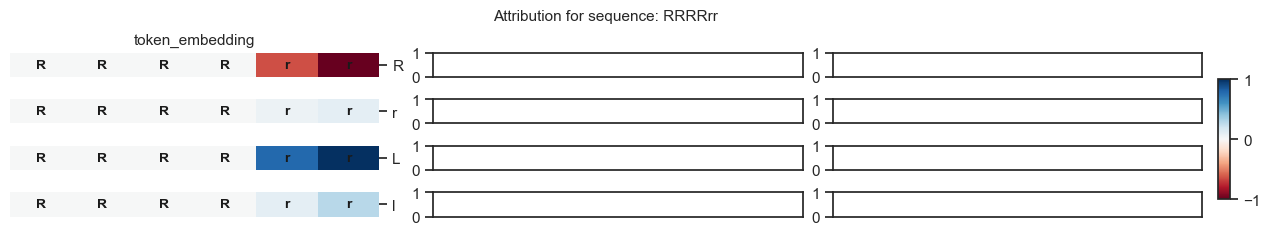

In [252]:
plot_attribution_all_targets(compute_integrated_gradients, model, ['RRRRrr'], vocab, stoi, steps=2, layers_of_interest=layers_to_analyze, ncols=len(layers_to_analyze))

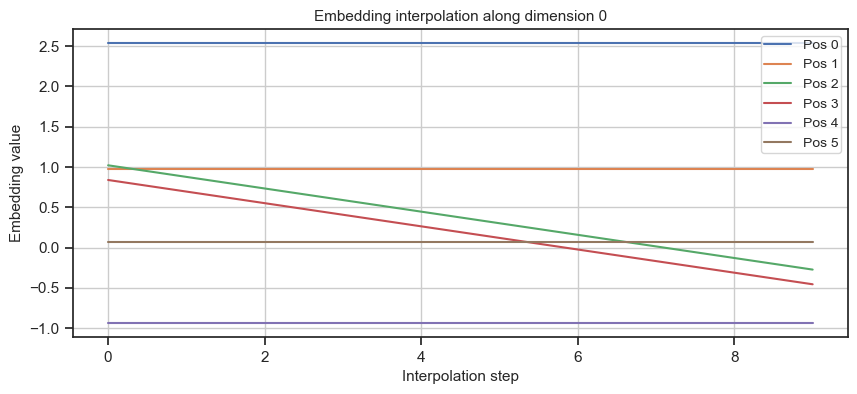

In [87]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 1. Set up vocab and mappings
vocab = ['A', 'B', 'C', 'D']
vocab_size = len(vocab)
token_to_id = {ch: i for i, ch in enumerate(vocab)}

# 2. Define model config
embedding_dim = 8
seq_length = 6

# 3. Token and positional embeddings
token_embed = nn.Embedding(vocab_size, embedding_dim)
position_embed = nn.Embedding(seq_length, embedding_dim)

# 4. Define inputs
input_tokens = ['A', 'A', 'B', 'B', 'A', 'A']      # target input
baseline_tokens = ['A', 'A', 'A', 'A', 'A', 'A']   # neutral baseline

input_ids = torch.tensor([token_to_id[tok] for tok in input_tokens])
baseline_ids = torch.tensor([token_to_id[tok] for tok in baseline_tokens])
positions = torch.arange(seq_length)

# 5. Get full embeddings (token + position)
def get_embeddings(token_ids):
    tok_embeds = token_embed(token_ids)
    pos_embeds = position_embed(positions)
    return tok_embeds + pos_embeds

input_embed = get_embeddings(input_ids)
baseline_embed = get_embeddings(baseline_ids)

# 6. Interpolate between baseline and input (IG path)
def interpolate_embeddings(baseline, input, steps=10):
    alphas = torch.linspace(0, 1, steps).view(steps, 1, 1)  # shape (steps, 1, 1)
    return baseline + alphas * (input - baseline)  # shape (steps, seq_len, emb_dim)

interpolated_embeds = interpolate_embeddings(baseline_embed, input_embed, steps=10)

# 7. Visualize one embedding dimension across sequence and steps
def plot_interpolation(interpolated, dim=0):
    # interpolated: (steps, seq_len, emb_dim)
    plt.figure(figsize=(10, 4))
    for i in range(seq_length):
        plt.plot(range(interpolated.shape[0]), interpolated[:, i, dim].detach().numpy(), label=f"Pos {i}")
    plt.title(f"Embedding interpolation along dimension {dim}")
    plt.xlabel("Interpolation step")
    plt.ylabel("Embedding value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_interpolation(interpolated_embeds, dim=0)


In [84]:
joint_probs

tensor([[[0.3669, 0.1572],
         [0.1903, 0.2855]]], grad_fn=<MulBackward0>)

### Manual gradient calculation

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F

n_samples = 1
n_features = 3
n_rewards = 2

# Dummy data
X = torch.randn(n_samples, n_features)
true_choice = torch.randint(0, 2, (n_samples,))      # 0 or 1
true_reward = torch.randint(0, n_rewards, (n_samples,))  # 0 or 1

# Construct joint class labels (choice * n_rewards + reward)
joint_targets = true_choice * n_rewards + true_reward  # class index in [0, 3]

# ---- 2. Binary Logistic Regression Model ---- #
class BinaryChoiceModel(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)  # one logit output

    def forward(self, x):
        logits = self.linear(x).squeeze(-1)  # shape: (batch,)
        p_choice = torch.sigmoid(logits)     # shape: (batch,)
        return p_choice

model = BinaryChoiceModel(n_features)

# ---- 3. Fixed reward filter: p(r | c) ---- #
# Shape: (2 choices, 2 rewards)
P_r_given_c = torch.tensor([
    [0.8, 0.2],  # reward given choice 0
    [0.2, 0.8]   # reward given choice 1
], dtype=torch.float32)

# ---- 4. Forward pass ---- #
p_choice = model(X)  # shape: (n_samples,)

# Convert to 2-column tensor: p(c=0), p(c=1)
p_choice_mat = torch.stack([1 - p_choice, p_choice], dim=1)  # shape: (n_samples, 2)

# Compute joint p(choice, reward)
# Shape: (n_samples, 2 choices, 2 rewards)
joint_probs = p_choice_mat.unsqueeze(2) * P_r_given_c.unsqueeze(0)

# Flatten to shape (n_samples, 4 classes)
joint_probs_flat = joint_probs.view(n_samples, -1)

# ---- 5. Cross-entropy loss ---- #
log_preds = torch.log(joint_probs_flat + 1e-8)  # avoid log(0)
loss = F.nll_loss(log_preds, joint_targets)

print("Loss:", loss.item())

model.zero_grad()
loss.backward()

Loss: 2.476320743560791
